In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

In [2]:
stocks = {
    'Tech': ['NVDA', 'DELL', 'INTC', 'QCOM', 'DBX'],
    'Middle_East_conflict': ['CVX', 'TRGP', 'LMT'],
    'Health_care': ['BSX', 'LLY', 'AMGN', 'BMY'],
    'Financial_services': ['TIGR', 'BRK-B'],
    'Consumer': ['JKS', 'LULU']
}

# Flatten the list of stocks
stock_list = [stock for group in stocks.values() for stock in group]

# Download historical stock data (5 years daily data)
data = yf.download(stock_list, start="2024-07-06", end="2024-10-07")['Adj Close']
#  test_data = yf.download(stock_list, start="2024-08-01", end="2024-09-21")['Adj Close']
#  this is for if you want to try testing the portfolio on a test set
#  you would need to adjust the end date of the data df so that they don't overlap
#  test_data.head()
data.tail()

[*********************100%***********************]  16 of 16 completed


Ticker,AMGN,BMY,BRK-B,BSX,CVX,DBX,DELL,INTC,JKS,LLY,LMT,LULU,NVDA,QCOM,TIGR,TRGP
Date,,,,,,,,,,,,,,,,
2024-09-30 00:00:00+00:00,322.209991,51.167233,460.260010,83.800003,147.270004,25.430000,118.540001,23.459999,26.820000,885.940002,584.559998,271.350006,121.440002,170.050003,5.34,148.009995
2024-10-01 00:00:00+00:00,320.320007,52.314392,457.410004,84.139999,149.699997,25.049999,113.160004,22.690001,25.530001,884.479980,605.859985,266.450012,117.000000,165.779999,6.23,150.580002
2024-10-02 00:00:00+00:00,319.730011,53.164867,456.670013,84.489998,150.949997,25.120001,113.459999,22.389999,25.530001,891.070007,603.200012,260.529999,118.849998,168.320007,8.06,153.240005
2024-10-03 00:00:00+00:00,317.480011,53.599998,452.959991,83.820000,151.250000,25.530001,115.669998,22.260000,26.090000,885.549988,605.820007,262.559998,122.849998,168.919998,9.19,155.500000
2024-10-04 00:00:00+00:00,319.660004,53.959999,461.970001,84.540001,150.740005,25.370001,120.419998,22.590000,29.940001,887.159973,605.130005,270.380005,124.919998,168.899994,12.39,158.020004


Optimal Weights: {'NVDA': 0.06994361980564627, 'DELL': 0.05137598899226725, 'INTC': 0.19999999999999982, 'QCOM': 0.19999999999999984, 'DBX': 0.07557972916360071, 'CVX': 0.04429567100565201, 'TRGP': 0.0, 'LMT': 0.0, 'BSX': 8.836247705756861e-18, 'LLY': 4.2934406030425976e-17, 'AMGN': 0.2, 'BMY': 2.0003530082357557e-17, 'TIGR': 3.503328269843786e-17, 'BRK-B': 0.020953066234264073, 'JKS': 1.6967763999398144e-17, 'LULU': 0.13785192479857}
Expected Portfolio Return: 0.6027916020908035
Expected Portfolio Volatility: 0.10307834118324416


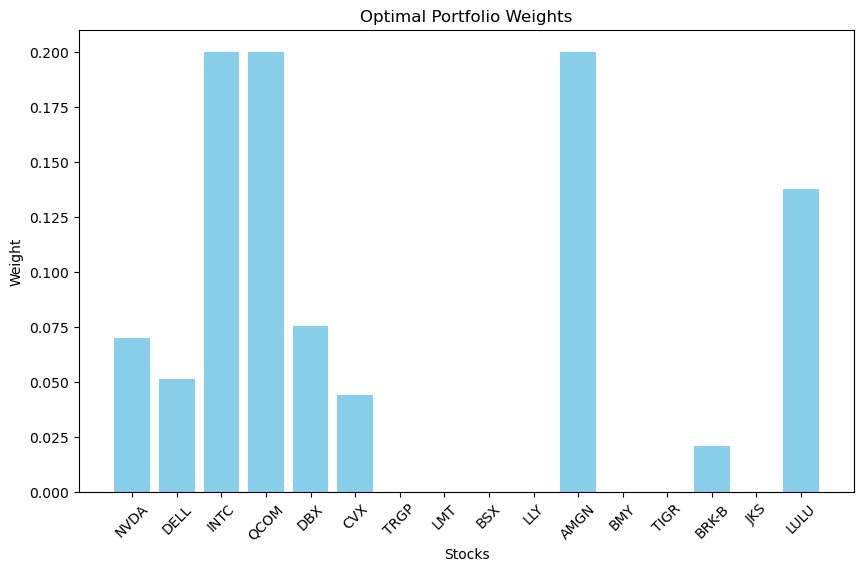

'\nyvals = []\nfor i in range(len(test_data.index)):\n    portfolio_returns = -1\n    for stock in stock_list:\n        portfolio_returns += res[stock] * test_data[stock].iloc[i] / data[stock].iloc[-1]\n    yvals.append(portfolio_returns)\nxvals = np.linspace(0, len(yvals)-1, len(yvals))\nplt.bar(xvals, yvals)\n'

In [3]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate expected returns (annualized)
expected_returns = returns.mean() * 252

# Calculate the covariance matrix (annualized)
cov_matrix = returns.cov() * 252

# Function to calculate portfolio performance
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Function to minimize (negative Sharpe ratio)
def minimize_volatility(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds: weights must be between 0 and 0.2
bounds = tuple((0, 0.2) for _ in range(len(stock_list)))

# Initial guess: equally distributed weights
init_guess = len(stock_list) * [1. / len(stock_list)]

# Optimization to minimize volatility (mean-variance optimization)
optimized_result = minimize(minimize_volatility, init_guess, args=(expected_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = optimized_result.x

# Calculate expected return and volatility for the optimized portfolio
opt_return, opt_volatility = portfolio_performance(optimal_weights, expected_returns, cov_matrix)

# Display results
res = dict(zip(stock_list, optimal_weights))
print("Optimal Weights:", res)
print("Expected Portfolio Return:", opt_return)
print("Expected Portfolio Volatility:", opt_volatility)

# Plot the optimal portfolio weights

plt.figure(figsize=(10,6))
plt.bar(stock_list, optimal_weights, color='skyblue')
plt.title('Optimal Portfolio Weights')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.show()


'''
yvals = []
for i in range(len(test_data.index)):
    portfolio_returns = -1
    for stock in stock_list:
        portfolio_returns += res[stock] * test_data[stock].iloc[i] / data[stock].iloc[-1]
    yvals.append(portfolio_returns)
xvals = np.linspace(0, len(yvals)-1, len(yvals))
plt.bar(xvals, yvals)
'''

#  above is for testing on test data